## Twitter Sentiment Analysis of India vs England Test Series Concluded in March 2021 

### Import Libraries 

In [274]:
from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
import pycountry
import re
import string

In [275]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

### Initialiaze variables for Twitter Authentication 

In [326]:
# Authentication
consumerKey = "Enter Your Consumer Key"
consumerSecret = "Enter Your Consumer Secret Key"
accessToken = "Enter Access Token"
accessTokenSecret = "Enter Access Token Secret"
auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth)

### Fetch Tweets : In this project we'll fetch #INDvsENG

We'll fetch 2000 tweets related to India vs England Test Series Concluded in March 2021.

In [339]:
#Sentiment Analysis

def percentage(part,whole):
    return 100 * float(part)/float(whole)

keyword = input("Please enter keyword or hashtag to search: ")
noOfTweet = int(input ("Please enter how many tweets to analyze: "))
tweets = tweepy.Cursor(api.search, q=keyword).items(noOfTweet)
positive = 0
negative = 0
neutral = 0
polarity = 0
tweet_list = []
neutral_list = []
negative_list = []
positive_list = []

# We'll use polarity_scores() function of SentimentIntensityAnalyzer() from vader package. It will give us a raw idea of  
# tweets sentiments. Also we'll see the polarity of raw tweets using TexBlob function of textblob package.

for tweet in tweets:
    tweet_list.append(tweet.text)
    analysis = TextBlob(tweet.text)
    score = SentimentIntensityAnalyzer().polarity_scores(tweet.text)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    polarity += analysis.sentiment.polarity

    if neg > pos:
        negative_list.append(tweet.text)
        negative += 1
    elif pos > neg:
        positive_list.append(tweet.text)
        positive += 1

    elif pos == neg:
        neutral_list.append(tweet.text)
        neutral += 1
    
positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')

Please enter keyword or hashtag to search: #INDvsENG
Please enter how many tweets to analyze: 2500


### Create a DataFrame of Tweets print total number of tweets i.e. positive, negative and neutral

In [340]:
#Number of Tweets (Total, Positive, Negative, Neutral)
tweet_list = pd.DataFrame(tweet_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)
print("total number: ",len(tweet_list))
print("positive number: ",len(positive_list))
print("negative number: ", len(negative_list))
print("neutral number: ",len(neutral_list))

total number:  2500
positive number:  1252
negative number:  210
neutral number:  1038


In [341]:
tweet_list

,0
0,RT @ChloeAmandaB: Okay well Kevin bhai can def...
1,RT @ChloeAmandaB: Okay well Kevin bhai can def...
2,RT @dhaikilokatweet: pant bhai op \n#INDvsENG ...
3,RT @dhaikilokatweet: pant bhai op \n#INDvsENG ...
4,After #INDvsENG test series ..\nGet ready for...
...,...
2495,RT @RahulGandhi: Congratulations to #TeamIndia...
2496,ಭಾರತ ಎದುರಿನ ಟಿ20 ಸರಣಿಗೂ ಮುನ್ನ ಇಂಗ್ಲೆಂಡ್‌ಗೆ ಬಿಗ...
2497,RT @virendersehwag: Congratulations Team India...
2498,RT @cricketnext: From Yuvraj Singh's Six Sixes...


### Remove Tweets other than in English 

In [342]:
Eng_Tweet = []
for tweet in tweets:
    print(tweet.text)
    if tweet.text.lang=="english":
        Eng_Tweet.append(tweet.text)

### Let's draw a Pie Chart to see the Tweets Sentiment Distribution based on Number of Tweets 

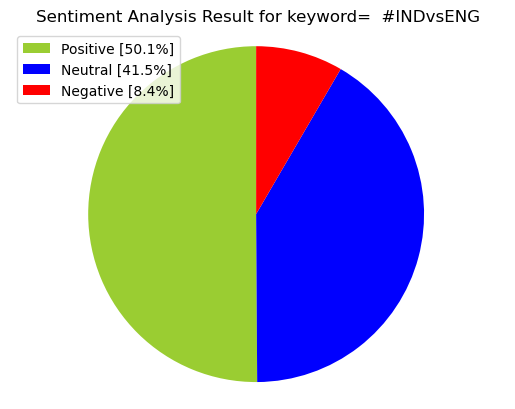

In [344]:
#Creating PieCart

labels = ['Positive ['+str(positive)+'%]' , 'Neutral ['+str(neutral)+'%]','Negative ['+str(negative)+'%]']
sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for keyword=  "+keyword+"" )
plt.axis('equal')
plt.show()

### Lets do some data cleaning 

In [345]:
tweet_list.duplicated().sum()

1173

In [346]:
tweet_list.drop_duplicates(inplace = True)

In [347]:
tweet_list.duplicated().sum()

0

In [348]:
tweet_list

,0
0,RT @ChloeAmandaB: Okay well Kevin bhai can def...
2,RT @dhaikilokatweet: pant bhai op \n#INDvsENG ...
4,After #INDvsENG test series ..\nGet ready for...
5,Agar mai mingle hota toh aaj mera break up ho ...
6,RT @RahulGandhi: Congratulations to #TeamIndia...
...,...
2487,"2 years ago, Rishabh Pant made wicket-keeping ..."
2488,RT @Drnpokhriyal: Was @RishabhPant17 a bit har...
2490,Former Australian skipper and #DelhiCapitals h...
2496,ಭಾರತ ಎದುರಿನ ಟಿ20 ಸರಣಿಗೂ ಮುನ್ನ ಇಂಗ್ಲೆಂಡ್‌ಗೆ ಬಿಗ...


### Removing Retweets, Punctuations and Commonly Occuring words

The 'text' column contains the cleaned tweets 

In [349]:
#Creating new dataframe and new features
tw_list = pd.DataFrame(tweet_list)
tw_list["text"] = tw_list[0]

#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x)
remove_http = lambda x : re.sub("(http)|(https)","",x)
rm_random = lambda x : re.sub("(indvseng)","",x)
tw_list["text"] = tw_list.text.map(remove_rt).map(rt).map(remove_http).map(rm_random)
tw_list["text"] = tw_list.text.str.lower()
tw_list.head(10)

,0,text
0,RT @ChloeAmandaB: Okay well Kevin bhai can def...,okay well kevin bhai can definitely bat in su...
2,RT @dhaikilokatweet: pant bhai op \n#INDvsENG ...,pant bhai op indvseng
4,After #INDvsENG test series ..\nGet ready for...,after indvseng test series get ready for ...
5,Agar mai mingle hota toh aaj mera break up ho ...,agar mai mingle hota toh aaj mera break up ho ...
6,RT @RahulGandhi: Congratulations to #TeamIndia...,congratulations to teamindia on a well deser...
7,Who's this Indian Guy?\nAnd why is he trending...,who s this indian guy and why is he trending ...
9,@ChloeAmandaB Original Sehwag of England @KP24...,original sehwag of england indvseng
11,RT @Piink_Shadowz: ⚠️WHOLE NATION 🌏 WANTS TO K...,whole nation wants to know where are ...
14,RT @ZeeNewsSports: इंग्लैड के लिए खतरे की घंटी...,indvseng hardi...
16,Sachin Tendulkar - The way Kevin Pietersen was...,sachin tendulkar the way kevin pietersen was...


### Lets do the Analysis now

In [350]:
for index, row in abc['text'].iteritems():
    print(index)
    print(row)
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    print(score)
    break

0
 205 10 not bad whether our guys will chase this down and give a lead of 100 atleast      
{'neg': 0.0, 'neu': 0.849, 'pos': 0.151, 'compound': 0.431}


In [351]:
#Calculating Negative, Positive, Neutral and Compound values

tw_list[['polarity', 'subjectivity']] = tw_list['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tw_list['text'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        tw_list.loc[index, 'sentiment'] = "negative"
    elif pos > neg:
        tw_list.loc[index, 'sentiment'] = "positive"
    else:
        tw_list.loc[index, 'sentiment'] = "neutral"
    tw_list.loc[index, 'neg'] = neg
    tw_list.loc[index, 'neu'] = neu
    tw_list.loc[index, 'pos'] = pos
    tw_list.loc[index, 'compound'] = comp

tw_list.head(10)

,0,text,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,RT @ChloeAmandaB: Okay well Kevin bhai can def...,okay well kevin bhai can definitely bat in su...,0.250000,0.500000,positive,0.0,0.573,0.427,0.6908
2,RT @dhaikilokatweet: pant bhai op \n#INDvsENG ...,pant bhai op indvseng,0.000000,0.000000,neutral,0.0,1.000,0.000,0.0000
4,After #INDvsENG test series ..\nGet ready for...,after indvseng test series get ready for ...,0.066667,0.500000,positive,0.0,0.865,0.135,0.3612
5,Agar mai mingle hota toh aaj mera break up ho ...,agar mai mingle hota toh aaj mera break up ho ...,-0.071429,0.214286,positive,0.0,0.753,0.247,0.5574
6,RT @RahulGandhi: Congratulations to #TeamIndia...,congratulations to teamindia on a well deser...,0.750000,0.525000,positive,0.0,0.541,0.459,0.9274
7,Who's this Indian Guy?\nAnd why is he trending...,who s this indian guy and why is he trending ...,0.000000,0.000000,neutral,0.0,1.000,0.000,0.0000
9,@ChloeAmandaB Original Sehwag of England @KP24...,original sehwag of england indvseng,0.375000,0.750000,positive,0.0,0.635,0.365,0.3182
11,RT @Piink_Shadowz: ⚠️WHOLE NATION 🌏 WANTS TO K...,whole nation wants to know where are ...,0.200000,0.250000,neutral,0.0,1.000,0.000,0.0000
14,RT @ZeeNewsSports: इंग्लैड के लिए खतरे की घंटी...,indvseng hardi...,0.000000,0.000000,neutral,0.0,1.000,0.000,0.0000
16,Sachin Tendulkar - The way Kevin Pietersen was...,sachin tendulkar the way kevin pietersen was...,0.000000,0.000000,positive,0.0,0.812,0.188,0.3540


Lets remove few more commonly occuring words which I realized after running wordcloud once

In [352]:
# Removing these keywords as they obviously appear a lot 
tw_list["text"] = tw_list["text"].str.replace("indvseng","",case=False)
tw_list["text"] = tw_list["text"].str.replace("indveng","",case=False)
tw_list["text"] = tw_list["text"].str.replace("India","",case=False)
tw_list["text"] = tw_list["text"].str.replace("England","",case=False)
tw_list["text"] = tw_list["text"].str.replace("cricket","",case=False)

Lets split data based on Sentiment

In [353]:
#Creating new data frames for all sentiments (positive, negative and neutral)

tw_list_negative = tw_list[tw_list["sentiment"]=="negative"]
tw_list_positive = tw_list[tw_list["sentiment"]=="positive"]
tw_list_neutral = tw_list[tw_list["sentiment"]=="neutral"]

In [354]:
#Function for count_values_in single columns

def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

In [355]:
#Count_values for sentiment
pc = count_values_in_column(tw_list,"sentiment")
pc

,Total,Percentage
neutral,678,51.09
positive,509,38.36
negative,140,10.55


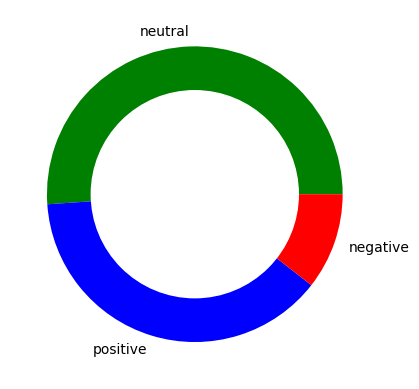

In [356]:
# create data for Pie Chart
pichart = count_values_in_column(tw_list,"sentiment")
names= pc.index
size=pc["Percentage"]
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','blue','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

### Lets draw a WordCloud 

In [357]:
# WordCloud Function

def create_wordcloud(text):
    mask = np.array(Image.open("F:/NLP Projects/cloud.png"))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white",
                  mask = mask,
                  max_words=9000,
                  stopwords=stopwords,
                  repeat=True)
    wc.generate(str(text))
    wc.to_file("F:/NLP Projects/wc.png")
    print("Word Cloud Saved Successfully")
    path="F:/NLP Projects/wc.png"
    display(Image.open(path))

Word Cloud Saved Successfully


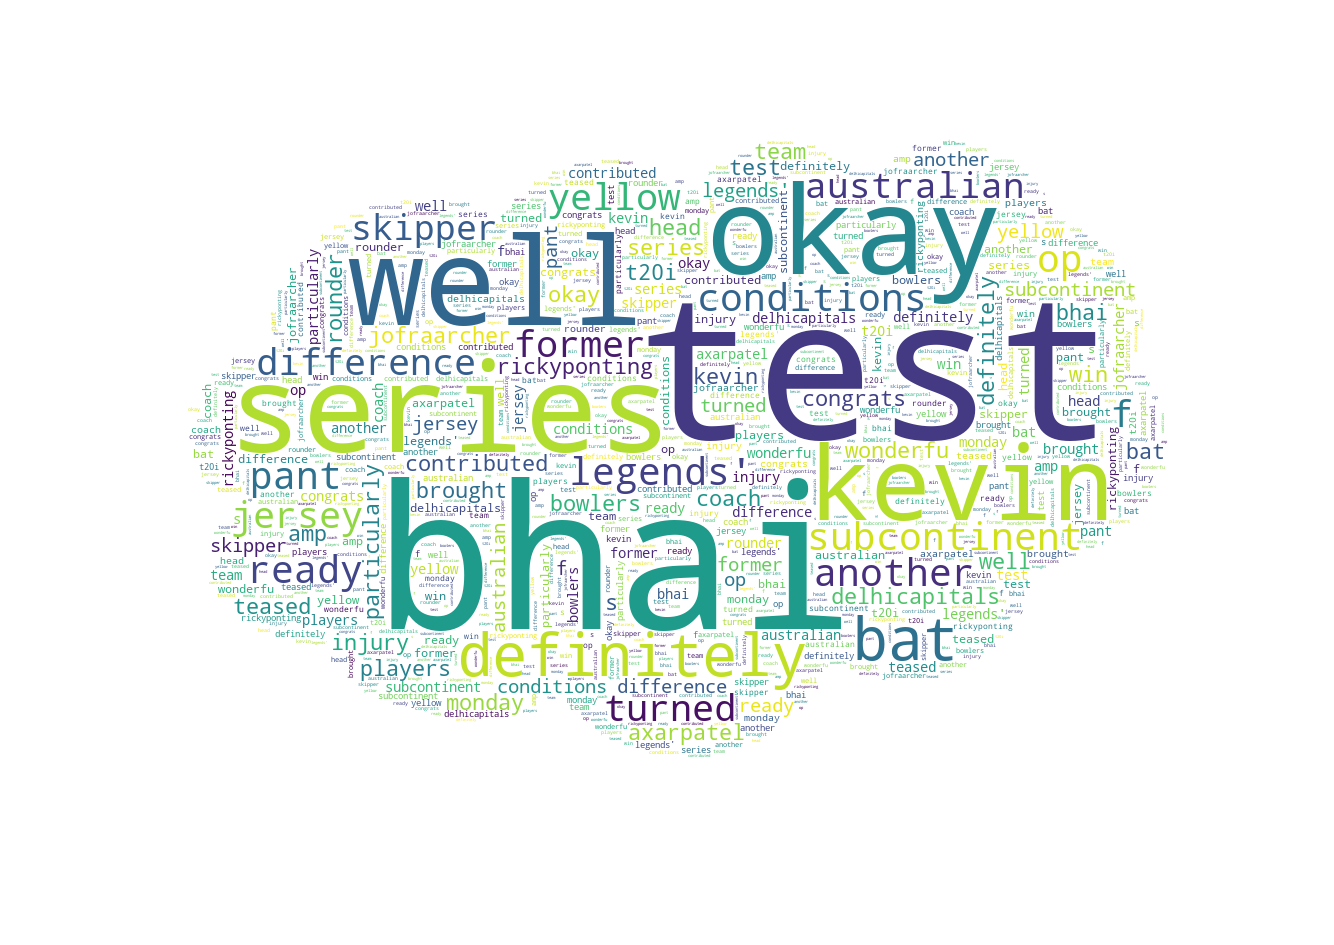

In [358]:
# WordCloud of Tweets
create_wordcloud(tw_list["text"].values)

### We can also create these clouds separately for each sentiment types 

<b>WordCloud for Positive Sentiments</b>

Word Cloud Saved Successfully


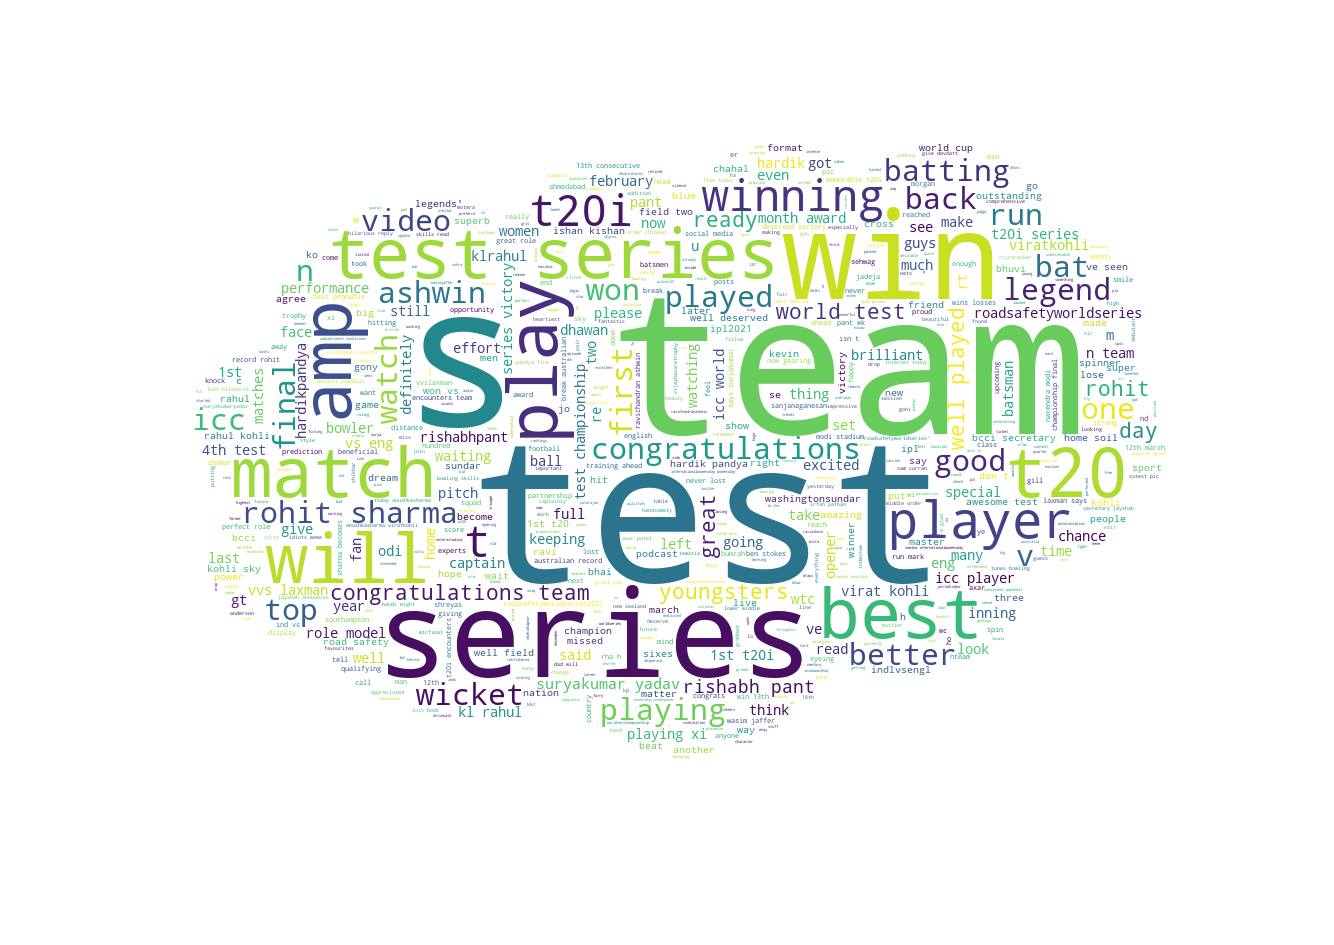

In [361]:
create_wordcloud(tw_list_positive['text'].values)

<b>WordCloud for Negative Sentiments</b>

Word Cloud Saved Successfully


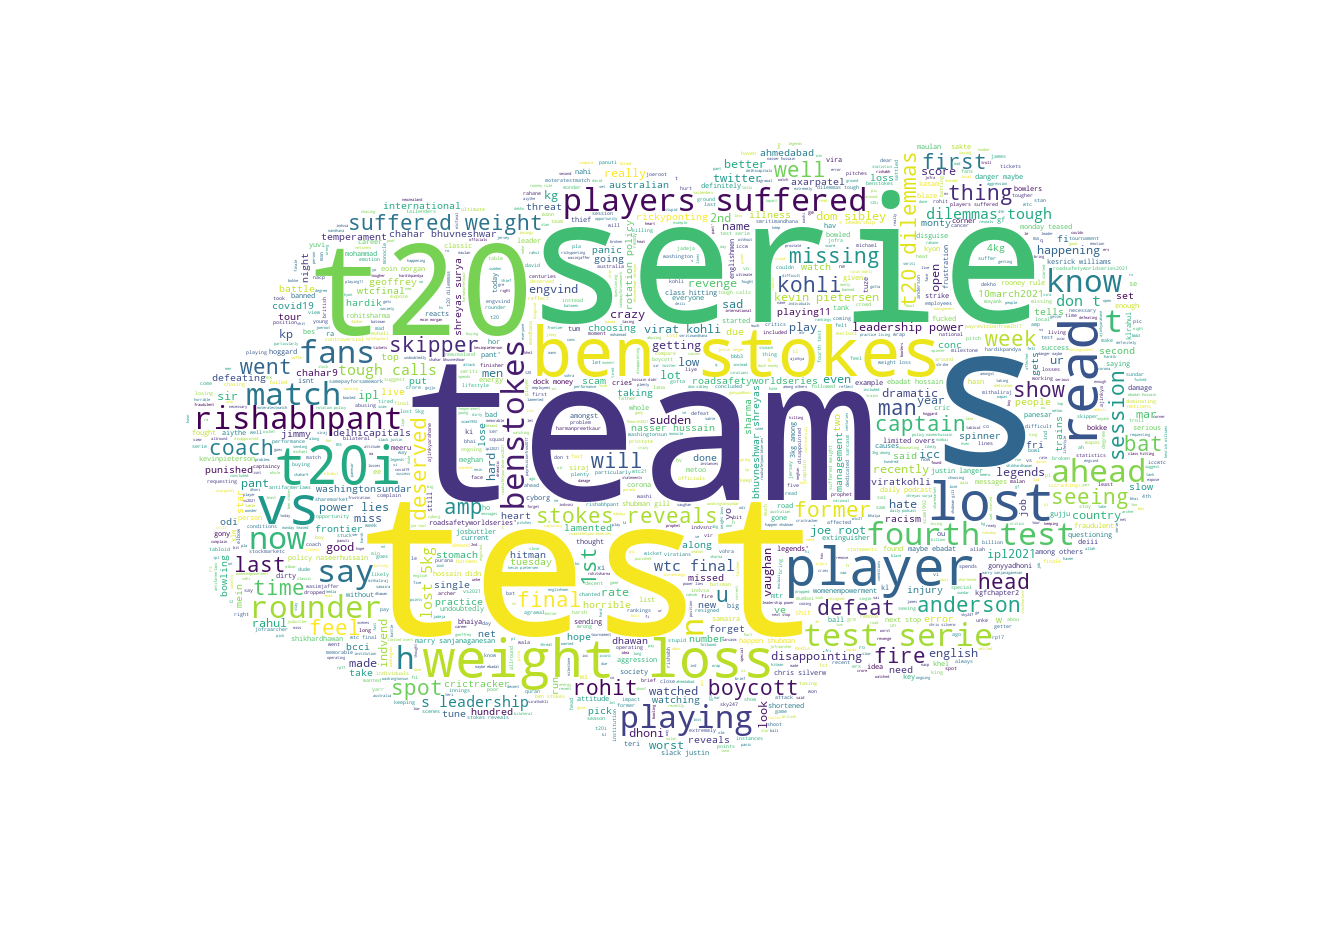

In [362]:
create_wordcloud(tw_list_negative['text'].values)

<b>WordCloud for Neutral Sentiments</b>

Word Cloud Saved Successfully


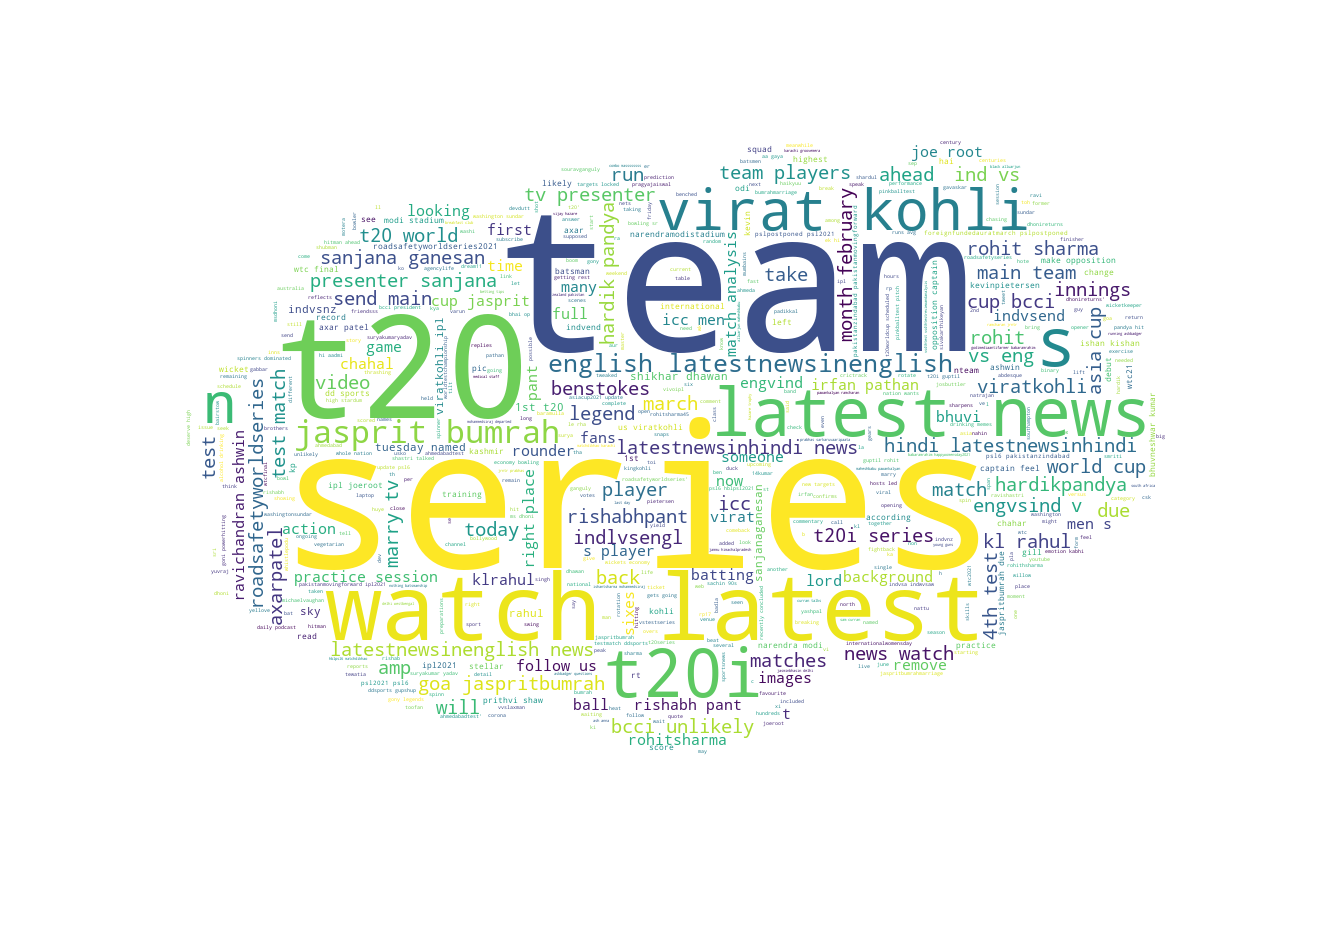

In [363]:
create_wordcloud(tw_list_neutral['text'].values)

### Lets check length of tweets and total words in each tweet 

In [364]:
tw_list['text_len'] = tw_list['text'].astype(str).apply(len)

In [365]:
tw_list['text_word_count'] = tw_list['text'].apply(lambda x: len(str(x).split()))

In [366]:
tw_list.head()

,0,text,polarity,subjectivity,sentiment,neg,neu,pos,compound,text_len,text_word_count
0,RT @ChloeAmandaB: Okay well Kevin bhai can def...,okay well kevin bhai can definitely bat in su...,0.250000,0.500000,positive,0.0,0.573,0.427,0.6908,80,11
2,RT @dhaikilokatweet: pant bhai op \n#INDvsENG ...,pant bhai op,0.000000,0.000000,neutral,0.0,1.000,0.000,0.0000,18,3
4,After #INDvsENG test series ..\nGet ready for...,after test series get ready for another ...,0.066667,0.500000,positive,0.0,0.865,0.135,0.3612,110,17
5,Agar mai mingle hota toh aaj mera break up ho ...,agar mai mingle hota toh aaj mera break up ho ...,-0.071429,0.214286,positive,0.0,0.753,0.247,0.5574,75,16
6,RT @RahulGandhi: Congratulations to #TeamIndia...,congratulations to team on a well deserved v...,0.750000,0.525000,positive,0.0,0.541,0.459,0.9274,115,20


<b>Text Length</b>

In [367]:
round(pd.DataFrame(tw_list.groupby('sentiment').text_len.mean()),2)

,text_len
sentiment,
negative,92.71
neutral,85.37
positive,95.87


<b>Word Count</b>

In [368]:
round(pd.DataFrame(tw_list.groupby('sentiment').text_word_count.mean()),2)

,text_word_count
sentiment,
negative,14.97
neutral,9.12
positive,15.61


<b>Removing Punctuation and Numeric values</b>

In [369]:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

tw_list['punct'] = tw_list['text'].apply(lambda x: remove_punct(x))

### Lets do Tokenization

In [370]:
from nltk.tokenize import word_tokenize

tw_list['tokenized'] = tw_list['punct'].apply(lambda x: word_tokenize(x.lower()))

### Remove Stopwords 

In [371]:
stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
tw_list['nonstop'] = tw_list['tokenized'].apply(lambda x: remove_stopwords(x))

### Stemming 

In [372]:
from nltk.stem.porter import PorterStemmer

ps = PorterStemmer()

def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

tw_list['stemmed'] = tw_list['nonstop'].apply(lambda x: stemming(x))

We'll also do Lemmatization as we would like to see if we get different results with two approaches.

### Lemmatization 

In [373]:
from nltk.stem.wordnet import WordNetLemmatizer

wn = WordNetLemmatizer()

def lemmatization(text):
    text = [wn.lemmatize(word) for word in text]
    return text

tw_list['Lemmatized'] = tw_list['nonstop'].apply(lambda x: lemmatization(x))

Let see how our dataframe looks like now.

In [374]:
tw_list.head()

,0,text,polarity,subjectivity,sentiment,neg,neu,pos,compound,text_len,text_word_count,punct,tokenized,nonstop,stemmed,Lemmatized
0,RT @ChloeAmandaB: Okay well Kevin bhai can def...,okay well kevin bhai can definitely bat in su...,0.250000,0.500000,positive,0.0,0.573,0.427,0.6908,80,11,okay well kevin bhai can definitely bat in su...,"[okay, well, kevin, bhai, can, definitely, bat...","[okay, well, kevin, bhai, definitely, bat, sub...","[okay, well, kevin, bhai, definit, bat, subcon...","[okay, well, kevin, bhai, definitely, bat, sub..."
2,RT @dhaikilokatweet: pant bhai op \n#INDvsENG ...,pant bhai op,0.000000,0.000000,neutral,0.0,1.000,0.000,0.0000,18,3,pant bhai op,"[pant, bhai, op]","[pant, bhai, op]","[pant, bhai, op]","[pant, bhai, op]"
4,After #INDvsENG test series ..\nGet ready for...,after test series get ready for another ...,0.066667,0.500000,positive,0.0,0.865,0.135,0.3612,110,17,after test series get ready for another ...,"[after, test, series, get, ready, for, another...","[test, series, get, ready, another, test, diff...","[test, seri, get, readi, anoth, test, differ, ...","[test, series, get, ready, another, test, diff..."
5,Agar mai mingle hota toh aaj mera break up ho ...,agar mai mingle hota toh aaj mera break up ho ...,-0.071429,0.214286,positive,0.0,0.753,0.247,0.5574,75,16,agar mai mingle hota toh aaj mera break up ho ...,"[agar, mai, mingle, hota, toh, aaj, mera, brea...","[agar, mai, mingle, hota, toh, aaj, mera, brea...","[agar, mai, mingl, hota, toh, aaj, mera, break...","[agar, mai, mingle, hota, toh, aaj, mera, brea..."
6,RT @RahulGandhi: Congratulations to #TeamIndia...,congratulations to team on a well deserved v...,0.750000,0.525000,positive,0.0,0.541,0.459,0.9274,115,20,congratulations to team on a well deserved v...,"[congratulations, to, team, on, a, well, deser...","[congratulations, team, well, deserved, victor...","[congratul, team, well, deserv, victori, th, t...","[congratulation, team, well, deserved, victory..."


### Apply CountVectorizer using Stemming

In [375]:
# We will use this function to clean our data during vectorization
def clean_text(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = word_tokenize(text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return text

In [376]:
# Apply countvectorizer to see counts of each word in the bag of words.

countVectorizer = CountVectorizer(analyzer=clean_text) 
countVector = countVectorizer.fit_transform(tw_list['text'])
print('{} Number of reviews has {} words'.format(countVector.shape[0], countVector.shape[1]))

1327 Number of reviews has 2163 words


In [377]:
count_vect_df = pd.DataFrame(countVector.toarray(), columns=countVectorizer.get_feature_names())
count_vect_df.head()

,aa,aadmi,aaj,aakashvani,aanedh,aap,aavangala,aawaz,aazadi,abdesqu,...,youtub,yuvi,yuvian,yuvraj,yuzvendra,yuzvendrachah,zeal,zealand,zeekal,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Let see Frequency of Words used in the Tweets 

In [378]:
count = pd.DataFrame(count_vect_df.sum())
countdf = count.sort_values(0,ascending=False).head(20)
countdf[1:11]

,0
test,199
seri,187
ti,118
play,99
match,98
vs,92
player,87
watch,86
news,83
win,77


### Let see how it changes when we use Lemmatization Instead of Stemming 

In [379]:
# We will use this function to clean our data during vectorization
def clean_text(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = word_tokenize(text_rc)    # tokenization
    text = [wn.lemmatize(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return text

In [380]:
# Apply countvectorizer to see counts of each word in the bag of words.

countVectorizer = CountVectorizer(analyzer=clean_text) 
countVector = countVectorizer.fit_transform(tw_list['text'])
print('{} Number of reviews has {} words'.format(countVector.shape[0], countVector.shape[1]))

1327 Number of reviews has 2360 words


In [381]:
count = pd.DataFrame(count_vect_df.sum())
countdf = count.sort_values(0,ascending=False).head(20)
countdf[1:11]

,0
test,199
seri,187
ti,118
play,99
match,98
vs,92
player,87
watch,86
news,83
win,77


Although the number of words are higher using Lemmatization but frequency of words hasn't changed much.

### We can also check how more than one word combined look 

In [382]:
#Function to ngram
def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [383]:
#n2_bigram
n2_bigrams = get_top_n_gram(tw_list['text'],(2,2),20)

n2_bigrams

[('test series', 60),
 ('virat kohli', 43),
 ('watch latest', 39),
 ('latest news', 39),
 ('14 15', 34),
 ('rohit sharma', 33),
 ('congratulations team', 28),
 ('world cup', 28),
 ('t20i series', 28),
 ('jasprit bumrah', 24),
 ('news english', 24),
 ('english latestnewsinenglish', 24),
 ('latestnewsinenglish news', 24),
 ('4th test', 23),
 ('sanjana ganesan', 23),
 ('vs eng', 23),
 ('player month', 23),
 ('rishabh pant', 22),
 ('t20 world', 22),
 ('bumrah marry', 22)]

In [384]:
#n3_trigram
n3_trigrams = get_top_n_gram(tw_list['text'],(3,3),20)

n3_trigrams

[('watch latest news', 39),
 ('latest news english', 24),
 ('news english latestnewsinenglish', 24),
 ('english latestnewsinenglish news', 24),
 ('t20 world cup', 22),
 ('jasprit bumrah marry', 22),
 ('sanjana ganesan 14', 20),
 ('bumrah marry tv', 19),
 ('marry tv presenter', 19),
 ('tv presenter sanjana', 19),
 ('presenter sanjana ganesan', 19),
 ('ganesan 14 15', 19),
 ('14 15 march', 19),
 ('15 march goa', 19),
 ('march goa jaspritbumrah', 18),
 ('series t20 world', 16),
 ('world cup bcci', 16),
 ('cup bcci unlikely', 16),
 ('bcci unlikely send', 16),
 ('unlikely send main', 16)]

### WordCloud After Lemmatization 

Word Cloud Saved Successfully


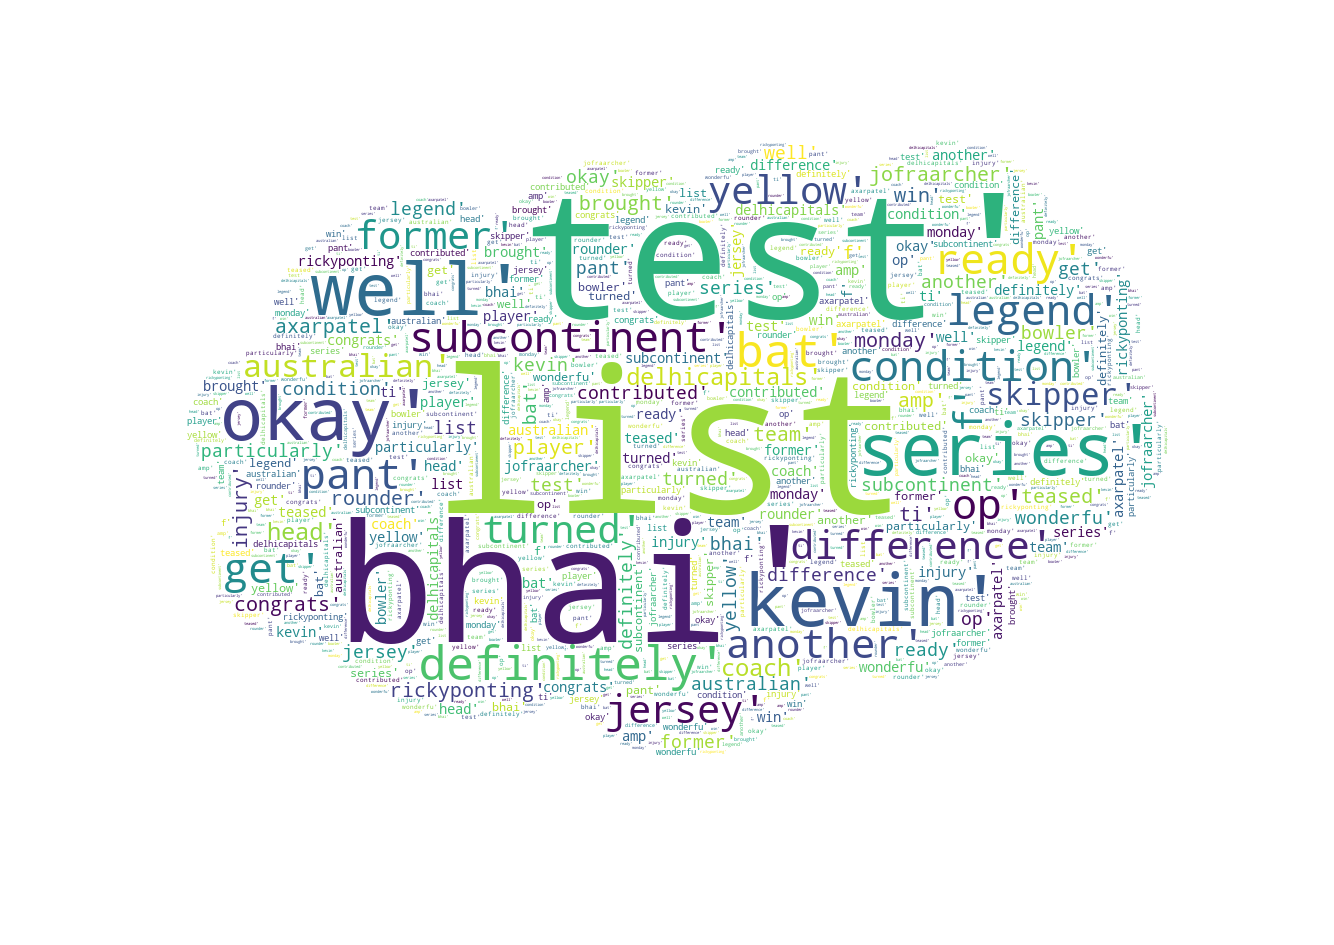

In [385]:
create_wordcloud(tw_list['Lemmatized'].values)